In [1]:
import matplotlib

%matplotlib inline
matplotlib.interactive(False)
import os
import warnings

warnings.filterwarnings("ignore")
from statistics import mean, median

import librosa
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
from noisereduce.noisereducev1 import reduce_noise
import sklearn
from mutagen.mp3 import MP3
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import seaborn as sb
sb.set(style="white", palette="muted")
import noisereduce as nr
import pydub
import numpy as np


N_FFT = 1024  # Number of frequency bins for Fast Fourier Transform
HOP_SIZE = 1024  # Number of audio frames between STFT columns
SR = 44100  # Sampling frequency
N_MELS = 30  # Mel band parameters
WIN_SIZE = 1024  # number of samples in each STFT window
WINDOW_TYPE = "hann"  # the windowin function
FEATURE = "mel"  # feature representation

BIRDS = [
    "0-Acant",
    "1-Acrid",
    "2-Alist",
    "3-Antho",
    "4-Antho",
    "5-Cacat",
    "6-Calyp",
    "7-Corvu",
    "8-Cract",
    "9-Dacel",
    "10-Eolop",
    "11-Eopsa",
    "12-Eudyn",
    "13-Grall",
    "14-Gymno",
    "15-Malur",
    "16-Manor",
    "17-Neoch",
    "18-Ocyph",
    "19-Parda",
    "20-Passe",
    "21-Phyli",
    "22-Platy",
    "23-Pycno",
    "24-Rhipi",
    "25-Rhipi",
    "26-Spilo",
    "27-Strep",
    "28-Trich",
    "29-Zoste"
]

In [3]:
birds = []
dire = 'E:/bird_data/'

for root, dirs, files in os.walk(dire + "xeno-canto-dataset-Australia-call/"):
    if root == dire + "xeno-canto-dataset-Australia-call/":
        birds = dirs
        
birds30 = []
flist_call = []
flist_song = []
flist_all = []

for i, bird in enumerate(birds):
    blist_call = []
    for root, dirs, files in os.walk(dire + "xeno-canto-dataset-Australia-call/" + bird):
        for file in files:
            if file.endswith(".mp3"):
                blist_call.append(os.path.join(root, file))
    flist_call.append(blist_call)
    
    blist_song = []
    for root, dirs, files in os.walk(dire + "xeno-canto-dataset-Australia-song/" + bird):
        for file in files:
            if file.endswith(".mp3"):
                blist_song.append(os.path.join(root, file))
    flist_song.append(blist_song)
    
    flist_all.append(blist_call + blist_song)
    birds30.append(bird)

print(len(flist_call[0]), len(flist_song[0]), len(flist_all[0]))

16 29 45


In [4]:
STRIDE = 0 #in second
clip_length = 5

class Clip:
    """A single 5-sec long recording."""
    class Audio:
        def __init__(self, path, raw):
            self.path = path
            self.raw = raw
    
    class AudioFile:
        """split the audios from one fold into 5 seconds clips, overlay applied
        
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage.
        """
        def __init__(self, path):
            self.path = path
            
        def __enter__(self):
            self.audios = []
            data_5s = pydub.AudioSegment.silent(duration=clip_length * 1000)
            
            for item in self.path:
                #split into 5 second clips
                
                #faster with massive memory use
                origin = pydub.AudioSegment.from_file(item)
                start = 0
                #have to reserve first 30 seconds in case of out of memory
                while start < origin.duration_seconds and start < 30:
                    data = data_5s.overlay(origin[start*1000:(start + clip_length)*1000])
                    raw =(np.fromstring(data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5)
                    start += clip_length - STRIDE

                    audio = Clip.Audio(item, raw)
                    self.audios.append(audio)

                #slower but save memory
#                 y, sr = librosa.load(item, mono=True)
#                 y, _ = librosa.effects.trim(y)
#                 y = reduce_noise(audio_clip=y, noise_clip=y, verbose=False)
#                 start = 0
#                 while start < librosa.get_duration(y=y, sr=sr) and start < 30:
#                     raw = y[start *sr: (start + clip_length) * sr]
#                     start += clip_length - STRIDE
                    
#                     audio = Clip.Audio(item, raw)
#                     self.audios.append(audio)
    
            return(self)
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.audios
        
    def __init__(self, filename, audio):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.directory = os.path.dirname(self.path)
        self.category = self.directory.split('/')[-1].split('\\')[-1]
        self.audio = audio
        
        self._compute_mfcc(audio)    
        self._compute_zcr(audio)
            
    def _compute_mfcc(self, audio):
        # MFCC computation with default settings
        self.melspectrogram = librosa.feature.melspectrogram(audio.raw, sr=SR, hop_length=WIN_SIZE)
        self.logamplitude = librosa.amplitude_to_db(self.melspectrogram)
        self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=15).transpose()
            
    def _compute_zcr(self, audio):
        # Zero-crossing rate
        self.zcr = []
        frames = int(np.ceil(clip_length / 1000.0 * SR / WIN_SIZE))
        
        for i in range(0, frames):
            frame = Clip._get_frame(audio, i)
            self.zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))

        self.zcr = np.asarray(self.zcr)
    
    @classmethod
    def _get_frame(cls, audio, index):
        if index < 0:
            return None
        return audio.raw[(index * WIN_SIZE):(index+1) * WIN_SIZE]
    
    def __repr__(self):
        return '<{0}/{1}>'.format(self.category, self.filename)

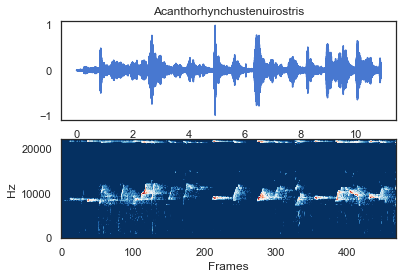

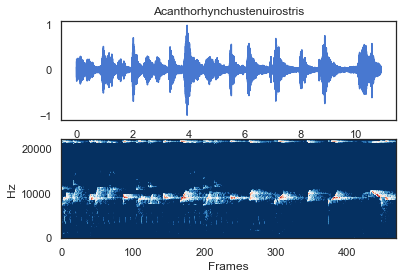

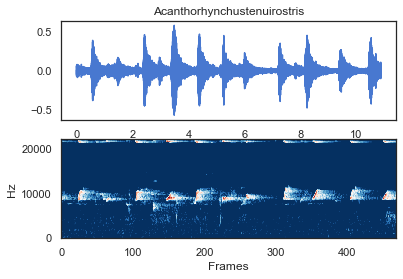

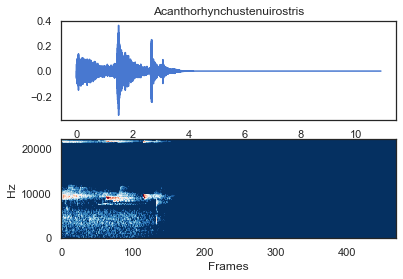

In [5]:
sample_audio_path = [flist_call[0][0]]
with Clip.AudioFile(sample_audio_path) as audio_list:
    audios = audio_list.audios
    for audio in audios:
        clip = Clip(audio.path, audio)
        
        plt.subplot(2, 1, 1)
        plt.title(clip.category)
        plt.plot(np.arange(0, len(audio.raw)) / float(SR), audio.raw)

        plt.subplot(2, 1, 2)
        librosa.display.specshow(clip.logamplitude, sr=SR, x_axis='frames', y_axis='linear', cmap='RdBu_r')

        plt.show()

IPython.display.Audio(filename=sample_audio_path[0], rate=SR)  

In [6]:
def displayTime(startFrame, endFrame):    
    print(' start time: ' + str(startFrame/sr) + ', end time: ' + str(endFrame/sr))

y: [ 7.3615898e-04  8.7345991e-04 -1.6166239e-04 ... -4.2219424e-05
  6.3362379e-05  0.0000000e+00]
y shape: (373460,)
Sample Rate (KHz): 22050
Check Len of Audio: 16.936961451247164 

Trimmed shape: (372224,)
Trimmed Len: 16.880907029478458 



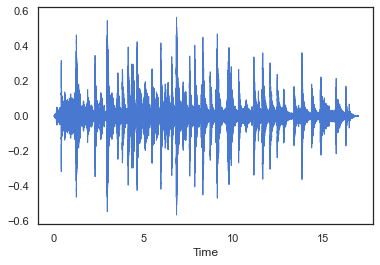

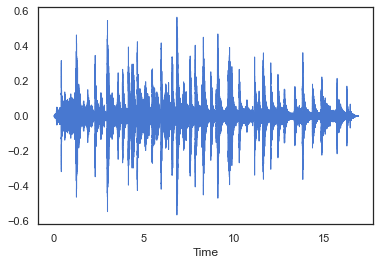

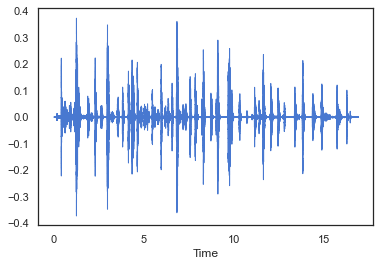

 start time: 0.09287981859410431, end time: 2.8328344671201813
 start time: 2.8560544217687074, end time: 4.017052154195011
 start time: 4.040272108843538, end time: 6.6873469387755105
 start time: 6.710566893424036, end time: 7.7090249433106575
 start time: 7.732244897959184, end time: 8.475283446712018
 start time: 8.614603174603175, end time: 8.893242630385487
 start time: 8.916462585034013, end time: 9.311201814058958
 start time: 9.566621315192744, end time: 10.031020408163265
 start time: 10.054240362811791, end time: 10.820498866213152
 start time: 10.913378684807256, end time: 11.842176870748299
 start time: 11.888616780045352, end time: 12.956734693877552
 start time: 13.165714285714285, end time: 13.25859410430839
 start time: 13.281814058956916, end time: 14.02485260770975
 start time: 14.048072562358277, end time: 14.164172335600908
 start time: 14.257052154195012, end time: 14.605351473922903
 start time: 14.744671201814059, end time: 16.555827664399093


In [7]:
y, sr = librosa.load(flist_call[0][0])
print('y:', y)
print('y shape:', np.shape(y))
print('Sample Rate (KHz):', sr)
print('Check Len of Audio:', np.shape(y)[0]/sr, '\n')

#trim the leading and trailing silence
trim_y, _ = librosa.effects.trim(y)
print('Trimmed shape:', np.shape(trim_y))
print('Trimmed Len:', np.shape(trim_y)[0]/sr, '\n')

librosa.display.waveshow(y)
plt.show()

librosa.display.waveshow(trim_y)
plt.show()
        
reduced_noise_y = nr.reduce_noise(y=trim_y, sr=sr)
librosa.display.waveshow(reduced_noise_y)
plt.show()

#split audio into non-silent intervals
sec = librosa.effects.split(reduced_noise_y)
for i in sec:
    displayTime(i[0], i[1])
plt.show()

In [7]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]], facecolor='w')

Time domain Features

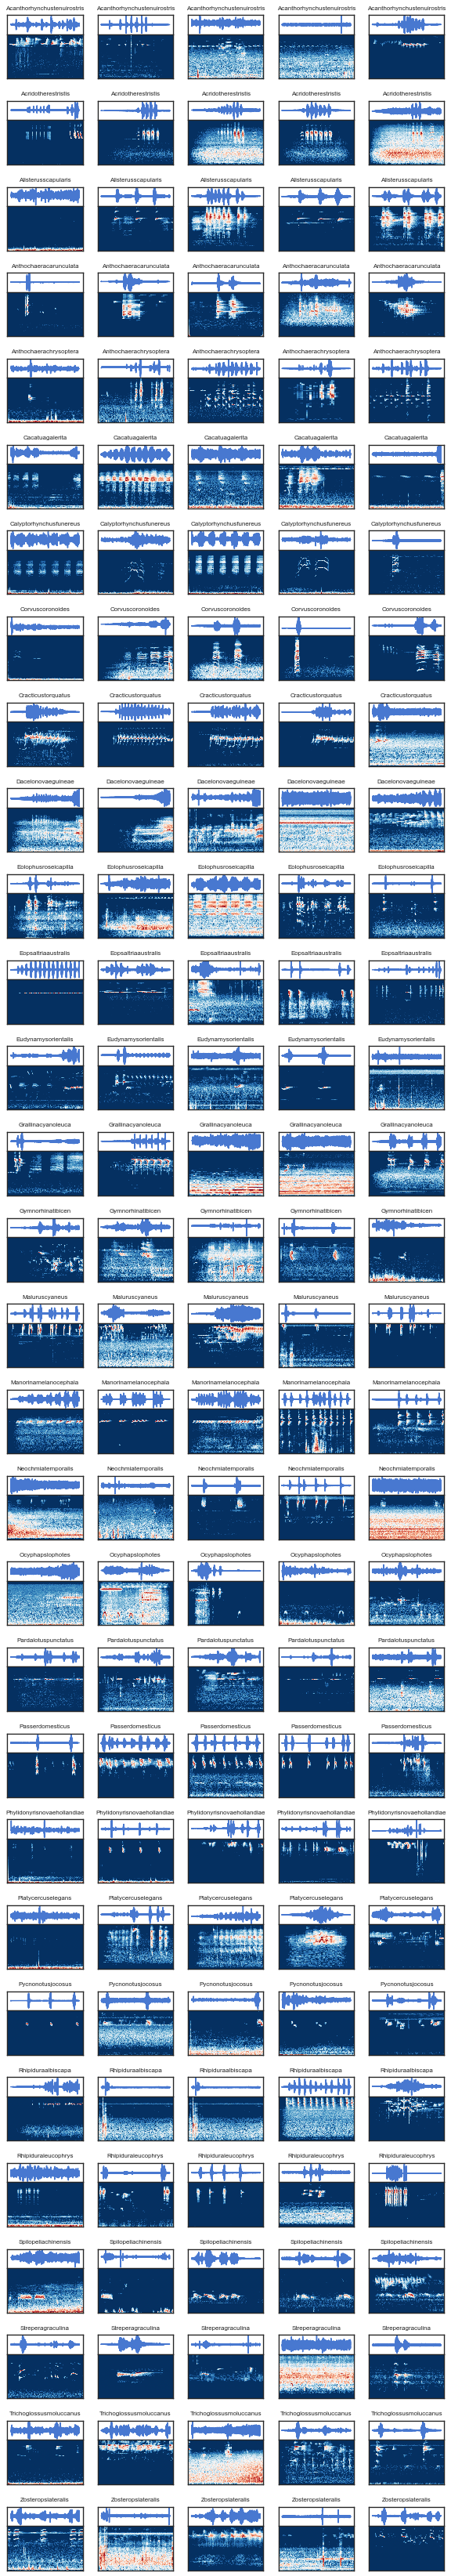

In [77]:
def plot_clip_overview(clip, ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    ax_waveform.plot(np.arange(0, len(clip.audio.raw)) / float(SR), clip.audio.raw)
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_waveform.set_title(clip.category, {'fontsize': 8}, y=1.03)
        
    librosa.display.specshow(clip.logamplitude, sr=SR, x_axis='time', y_axis='mel', cmap='RdBu_r')
    ax_spectrogram.get_xaxis().set_visible(False)
    ax_spectrogram.get_yaxis().set_visible(False)
        
clips_shown = 5
f, axes = plt.subplots(len(BIRDS), clips_shown, figsize=(clips_shown * 2, len(BIRDS) * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for c in range(0, len(BIRDS)):
    for i in range(0, clips_shown):
        with Clip.AudioFile([flist_call[c][i]]) as audio_list:
            audio = audio_list.audios[0]
            clip = Clip(audio.path, audio)
            plot_clip_overview(clip, axes[c, i])
    
plt.show()


single clip / all features perspective:

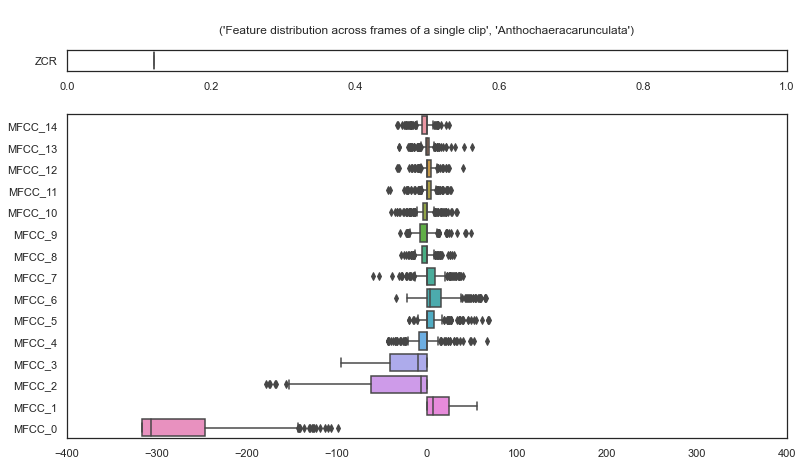

In [13]:
def plot_single_clip(clip):
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(clip.mfcc)[1]))
    MFCC = pd.DataFrame(clip.mfcc[:, :], columns=col_names)

    f = plt.figure(figsize=(10, 6))
    ax = f.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.75])
    ax_mfcc.set_xlim(-400, 400)
    ax_zcr = add_subplot_axes(ax, [0.0, 0.85, 1.0, 0.05])
    ax_zcr.set_xlim(0.0, 1.0)

    plt.title(('Feature distribution across frames of a single clip', clip.category), y=1.5)
    sb.boxplot(data=MFCC, orient="h", order=list(reversed(MFCC.columns)), ax=ax_mfcc)
    sb.boxplot(data=pd.DataFrame(clip.zcr, columns=['ZCR']),  orient="h", ax=ax_zcr)
  
with Clip.AudioFile([flist_call[3][10]]) as audio_list:
    audio = audio_list.audios[0]
    clip = Clip(audio.path, audio)
    plot_single_clip(clip)
    plt.show()

𝑀𝐹𝐶𝐶1  with an all clips / single feature

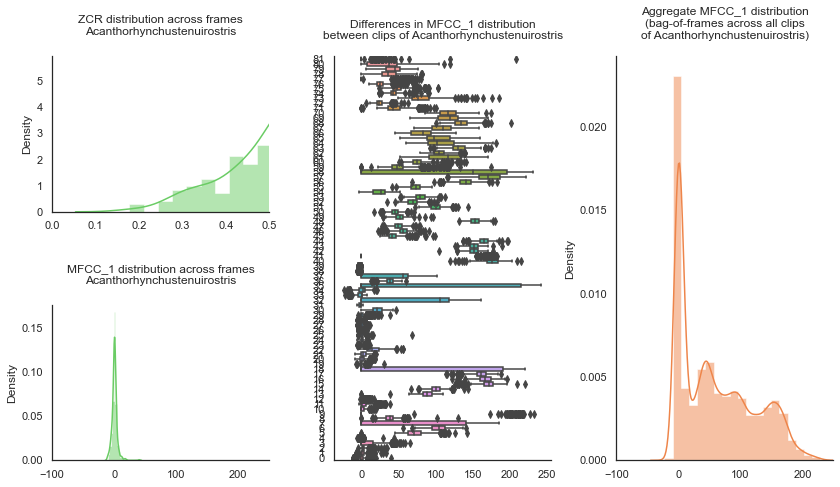

In [29]:
clips1 = []
with Clip.AudioFile(flist_call[0]) as audio_list:
    audios = audio_list.audios
    for audio in audios:
        clip = Clip(audio.path, audio)
        clips1.append(clip)
    
def plot_single_feature_one_clip(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.10)
    sb.distplot(feature, bins=20, hist=True, rug=False,
                hist_kws={"histtype": "stepfilled", "alpha": 0.5},
                kde_kws={"shade": False},
                color=sb.color_palette("muted", 4)[2], ax=ax)

def plot_single_feature_all_clips(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.03)
    sb.boxplot(data=feature, orient="h", order=list(reversed(feature.columns)), ax=ax)

def plot_single_feature_aggregate(feature, title, ax):    
    sb.despine()
    ax.set_title(title, y=1.03)
    sb.distplot(feature, bins=20, hist=True, rug=False,
                hist_kws={"histtype": "stepfilled", "alpha": 0.5},
                kde_kws={"shade": False},
                color=sb.color_palette("muted", 4)[1], ax=ax)

def generate_feature_summary(clip, coefficient):
    title = clips1[clip].category
    MFCC = pd.DataFrame()
    aggregate = []
    for i in range(0, len(clips1)):
        current_mfcc = clips1[i].mfcc[:, coefficient]
        MFCC[i] = pd.DataFrame(current_mfcc)
        aggregate = np.concatenate([aggregate, clips1[i].mfcc[:, coefficient]])    

    f = plt.figure(figsize=(14, 12))
    f.subplots_adjust(hspace=0.6, wspace=0.3)

    ax1 = plt.subplot2grid((3, 3), (0, 0))
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (0, 1), rowspan=2)
    ax4 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)

    ax1.set_xlim(0.0, 0.5)
    ax2.set_xlim(-100, 250)
    ax4.set_xlim(-100, 250)
    
    plot_single_feature_one_clip(clips1[clip].zcr, 'ZCR distribution across frames\n{0}'.format(title), ax1)
    plot_single_feature_one_clip(clips1[clip].mfcc[:, coefficient], 'MFCC_{0} distribution across frames\n{1}'.format(coefficient, title), ax2)

    plot_single_feature_all_clips(MFCC, 'Differences in MFCC_{0} distribution\nbetween clips of {1}'.format(coefficient, clips1[clip].category), ax3)

    plot_single_feature_aggregate(aggregate, 'Aggregate MFCC_{0} distribution\n(bag-of-frames across all clips\nof {1})'.format(coefficient, clips1[clip].category), ax4)

generate_feature_summary(0, 1)    
plt.show()

In [6]:
clip30 = []
for file in flist_call:
    clip1 = []
    if len(file) > 10: file = file[:10]
    with Clip.AudioFile(file) as audio_list:
        audios = audio_list.audios
        for audio in audios:
            clip = Clip(audio.path, audio)
            clip1.append(clip)
    clip30.append(clip1)
    
clip30

[[<Acanthorhynchustenuirostris/C:\Users\Admin\Desktop\Australian_Birds_Classification\data\xeno-canto-dataset-Australia-call\Acanthorhynchustenuirostris\Acanthorhynchustenuirostris146133.mp3>,
  <Acanthorhynchustenuirostris/C:\Users\Admin\Desktop\Australian_Birds_Classification\data\xeno-canto-dataset-Australia-call\Acanthorhynchustenuirostris\Acanthorhynchustenuirostris146133.mp3>,
  <Acanthorhynchustenuirostris/C:\Users\Admin\Desktop\Australian_Birds_Classification\data\xeno-canto-dataset-Australia-call\Acanthorhynchustenuirostris\Acanthorhynchustenuirostris146133.mp3>,
  <Acanthorhynchustenuirostris/C:\Users\Admin\Desktop\Australian_Birds_Classification\data\xeno-canto-dataset-Australia-call\Acanthorhynchustenuirostris\Acanthorhynchustenuirostris146133.mp3>,
  <Acanthorhynchustenuirostris/C:\Users\Admin\Desktop\Australian_Birds_Classification\data\xeno-canto-dataset-Australia-call\Acanthorhynchustenuirostris\Acanthorhynchustenuirostris146133.mp3>,
  <Acanthorhynchustenuirostris/C:\U

all clips / all features:

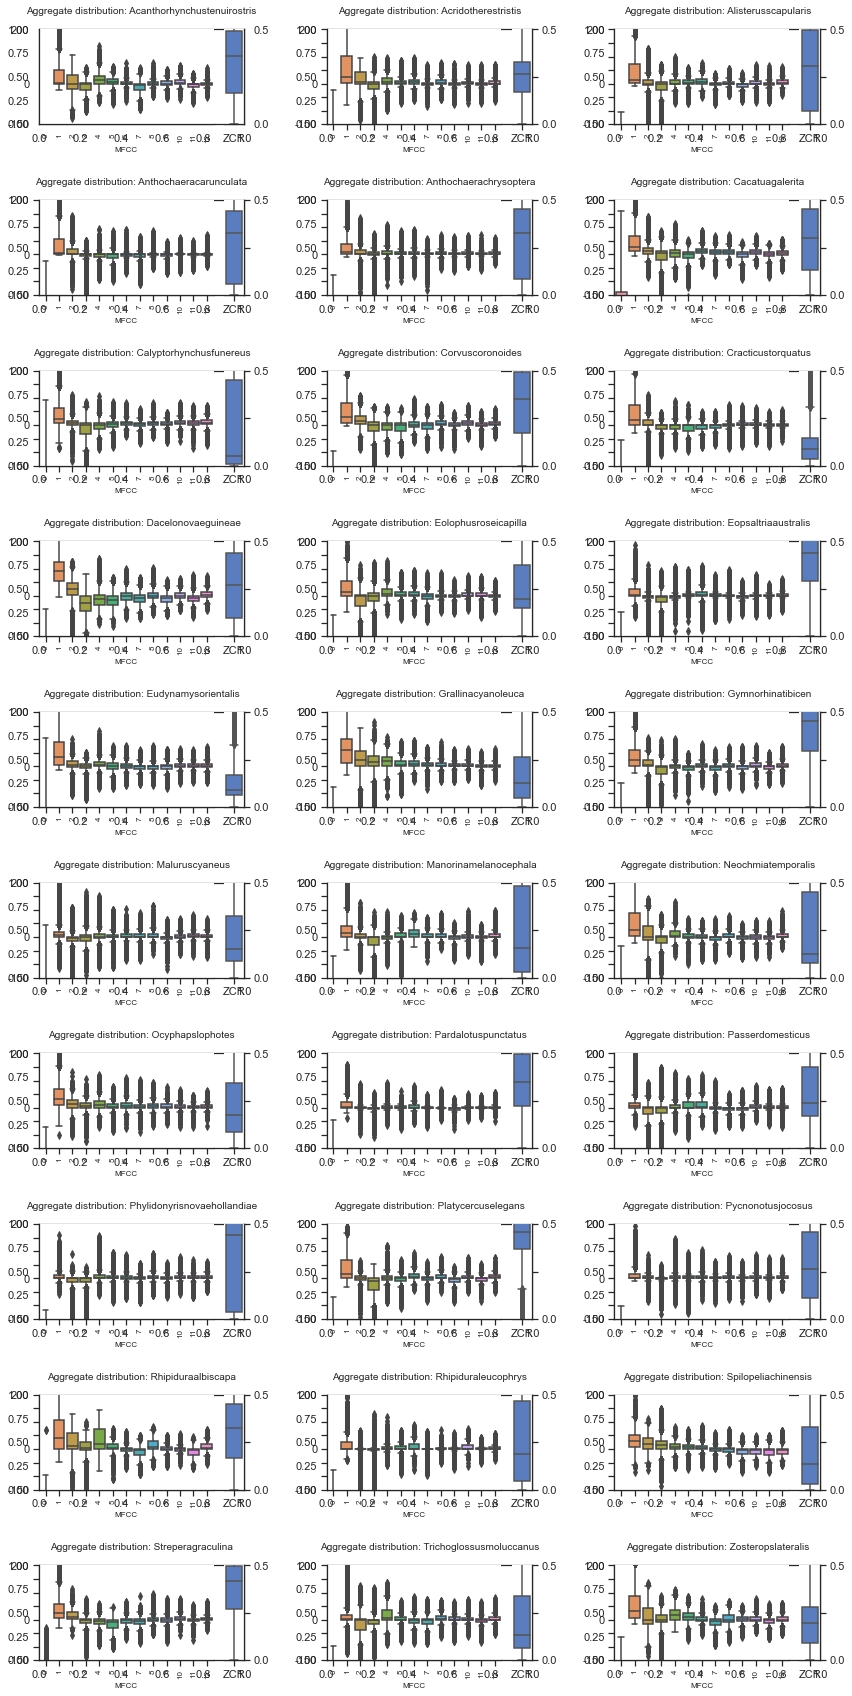

In [32]:
def plot_all_features_aggregate(clips, ax):
    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 0.85, 1.0])
    ax_zcr = add_subplot_axes(ax, [0.9, 0.0, 0.1, 1.0])
    
    sb.set_style('ticks')
    
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(clips[0].mfcc)[1]))
    aggregated_mfcc = pd.DataFrame(clips[0].mfcc[:, :], columns=col_names)

    for i in range(1, len(clips)):
        aggregated_mfcc = aggregated_mfcc.append(pd.DataFrame(clips[i].mfcc[:, :], columns=col_names))
        
    aggregated_zcr = pd.DataFrame(clips[0].zcr, columns=['ZCR']) 
    for i in range(1, len(clips)):
        aggregated_zcr = aggregated_zcr.append(pd.DataFrame(clips[i].zcr, columns=['ZCR']))
    
    sb.despine(ax=ax_mfcc)
    ax.set_title('Aggregate distribution: {0}'.format(clips[0].category), y=1.10, fontsize=10)
    sb.boxplot(data=aggregated_mfcc, orient="v", order=list(aggregated_mfcc.columns), ax=ax_mfcc)
    ax_mfcc.set_xticklabels(range(0, 13), rotation=90, fontsize=8)
    ax_mfcc.set_xlabel('MFCC', fontsize=8)
    ax_mfcc.set_ylim(-150, 200)
    ax_mfcc.set_yticks((-150, -100, -50, 0, 50, 100, 150, 200))
    ax_mfcc.set_yticklabels(('-150', '', '', '0', '', '', '', '200'))
    
    sb.despine(ax=ax_zcr, right=False, left=True)
    sb.boxplot(data=aggregated_zcr, orient="v", order=list(aggregated_zcr.columns), ax=ax_zcr)
    ax_zcr.set_ylim(0.0, 0.5)
    ax_zcr.set_yticks((0.0, 0.25, 0.5))
    ax_zcr.set_yticklabels(('0.0', '', '0.5'))

categories = 30
    
f, axes = plt.subplots(int(np.ceil(categories / 3.0)), 3, figsize=(14, categories * 1))
f.subplots_adjust(hspace=0.8, wspace=0.4)

map(lambda ax: ax.get_xaxis().set_visible(False), axes.flat)
map(lambda ax: ax.get_yaxis().set_visible(False), axes.flat)
map(lambda ax: ax.set_frame_on(False), axes.flat)

for c in range(0, categories):
    plot_all_features_aggregate(clip30[c], axes.flat[c])
plt.show()

In [33]:
def plot_features_scatter(feature1, feature2, category, category_name, ax, legend='small',
                          pretty_labels=None, font=None, crop_right=None):
    if font is None:
        font = matplotlib.font_manager.FontProperties()
   
    sb.despine()
    #category_count = len(clip_features['category'].unique())
    category_count = 10
    colors = sb.color_palette("Set3", 10)
    plots = []
    labels = []
    markers = [
        '^',     # Triangle up
        'D',     # Rotated square
        'v',   # Triangle down
        '>',   # Triangle right
        '*',     # Star (6)
        '<',    # Triangle left
        'x',     # Star (5)
        's',    # Square
        '+',     # Star (8)
        '8'      # Circle
    ]
    
    for c in range(0, category_count):
        f1 = feature1[category == c]
        f2 = feature2[category == c]
        size = 50 if c != 9 else 35
        plots.append(ax.scatter(f1, f2, color=colors[c], s=size, marker=markers[c]))
        labels.append(category_name[category == c][0:1][0])

    font.set_size(11)
    ax.set_xlabel(feature1.name, fontproperties=font)
    ax.set_ylabel(feature2.name, fontproperties=font)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.3)
    ax.set_xticklabels(ax.get_xticks(), fontproperties=font)
    ax.set_yticklabels(ax.get_yticks(), fontproperties=font)
    
    if crop_right is not None:
        ax.set_xlim(ax.get_xlim()[0], crop_right)
    
    if pretty_labels is not None:
        labels = pretty_labels
    
    if legend == 'small':
        ax.legend(plots, labels, ncol=2, loc='upper center', frameon=False, fancybox=False, borderpad=1.0, prop=font)
    elif legend == 'big':
        font.set_size(11)
        ax.legend(plots, labels, ncol=5, columnspacing=2, markerscale=1.5, loc='upper center', frameon=False, fancybox=False, borderpad=1.0, prop=font)

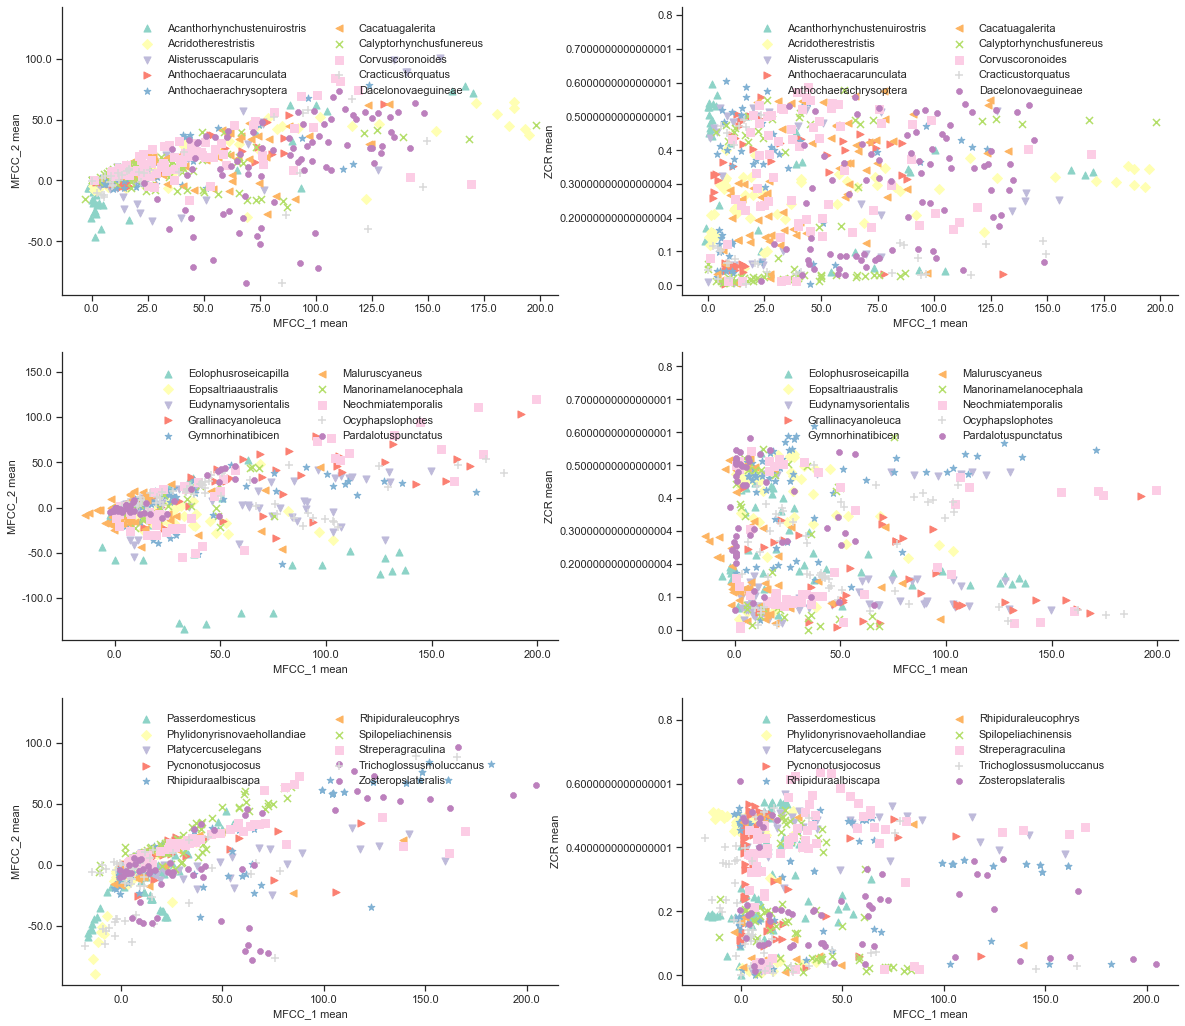

In [34]:
def get_clip_features(clip):
    clip_features = pd.DataFrame()
    for c in range(0, len(clip)):
        for i in range(0, len(clip[c])):
            col_names_mean = list('MFCC_{} mean'.format(i) for i in range(np.shape(clip[c][i].mfcc)[1]))
            col_names_std = list('MFCC_{} std dev'.format(i) for i in range(np.shape(clip[c][i].mfcc)[1]))
            current = pd.DataFrame(np.mean(pd.DataFrame(clip[c][i].mfcc[:, :]))[:,np.newaxis].transpose(), columns=col_names_mean)
            current = current.join(pd.DataFrame(np.std(pd.DataFrame(clip[c][i].mfcc[:, :]))[:,np.newaxis].transpose(), columns=col_names_std))
            current['ZCR mean'] = np.mean(clip[c][i].zcr)
            current['ZCR std dev'] = np.std(clip[c][i].zcr)
            current['category'] = c
            current['category_name'] = clip[c][i].category
            current['clip'] = i
            clip_features = clip_features.append(current)
    return clip_features

clip30_1 = get_clip_features(clip30[:10])
clip30_2 = get_clip_features(clip30[10:20])
clip30_3 = get_clip_features(clip30[20:])

f, axes = plt.subplots(3, 2, figsize=(20, 18))
plot_features_scatter(clip30_1['MFCC_1 mean'], clip30_1['MFCC_2 mean'], clip30_1['category'], clip30_1['category_name'], axes[0, 0])
plot_features_scatter(clip30_1['MFCC_1 mean'], clip30_1['ZCR mean'], clip30_1['category'], clip30_1['category_name'], axes[0, 1])
plot_features_scatter(clip30_2['MFCC_1 mean'], clip30_2['MFCC_2 mean'], clip30_2['category'], clip30_2['category_name'], axes[1, 0])
plot_features_scatter(clip30_2['MFCC_1 mean'], clip30_2['ZCR mean'], clip30_2['category'], clip30_2['category_name'], axes[1, 1])
plot_features_scatter(clip30_3['MFCC_1 mean'], clip30_3['MFCC_2 mean'], clip30_3['category'], clip30_3['category_name'], axes[2, 0])
plot_features_scatter(clip30_3['MFCC_1 mean'], clip30_3['ZCR mean'], clip30_3['category'], clip30_3['category_name'], axes[2, 1])
plt.subplots_adjust(wspace=0.25)
plt.show()

principal component analysis (PCA)

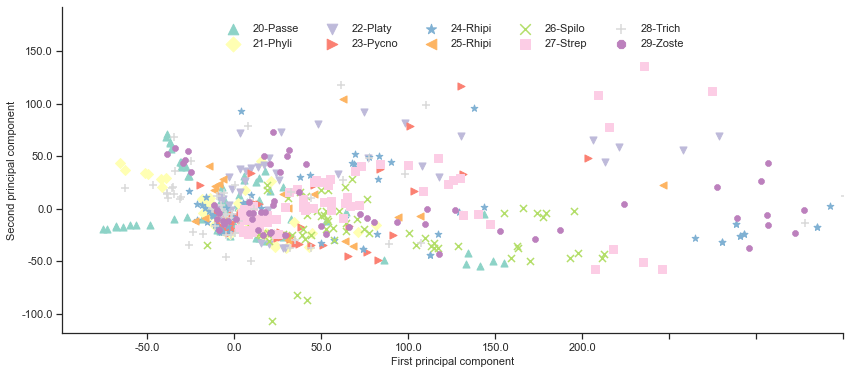

In [35]:
import sklearn as sk

pca = sk.decomposition.PCA(n_components=2)
pca.fit(clip30_3.loc[:, 'MFCC_1 mean':'ZCR std dev'])
X = pca.transform(clip30_3.loc[:, 'MFCC_1 mean':'ZCR std dev'])
clip30_3['First principal component'] = X[:, 0]
clip30_3['Second principal component'] = X[:, 1]

f, axes = plt.subplots(1, 1, figsize=(14, 6))

plot_features_scatter(clip30_3['First principal component'], 
                      clip30_3['Second principal component'],
                      clip30_3['category'], 
                      clip30_3['category_name'],
                      axes, 'big', BIRDS[20:], crop_right=150)

plt.show()

In [35]:
clip_all = []
for file in flist_call:
    print(file)
    clip1 = []
    with Clip.AudioFile(file) as audio_list:
        audios = audio_list.audios
        for audio in audios:
            clip1.append(Clip(audio.path, audio))
    clip_all.append(clip1)
    
clip_all

['E:/bird_data/xeno-canto-dataset-Australia-call/Acanthorhynchustenuirostris\\Acanthorhynchustenuirostris146133.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Acanthorhynchustenuirostris\\Acanthorhynchustenuirostris171970.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Acanthorhynchustenuirostris\\Acanthorhynchustenuirostris187354.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Acanthorhynchustenuirostris\\Acanthorhynchustenuirostris256709.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Acanthorhynchustenuirostris\\Acanthorhynchustenuirostris357302.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Acanthorhynchustenuirostris\\Acanthorhynchustenuirostris380644.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Acanthorhynchustenuirostris\\Acanthorhynchustenuirostris390576.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Acanthorhynchustenuirostris\\Acanthorhynchustenuirostris495651.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Acanthorhynchus

['E:/bird_data/xeno-canto-dataset-Australia-call/Alisterusscapularis\\Alisterusscapularis104748.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Alisterusscapularis\\Alisterusscapularis140226.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Alisterusscapularis\\Alisterusscapularis146124.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Alisterusscapularis\\Alisterusscapularis171954.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Alisterusscapularis\\Alisterusscapularis172017.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Alisterusscapularis\\Alisterusscapularis177809.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Alisterusscapularis\\Alisterusscapularis187881.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Alisterusscapularis\\Alisterusscapularis234966.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Alisterusscapularis\\Alisterusscapularis247356.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Alisterusscapularis\\Alisterusscapularis28

['E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Cacatuagalerita104974.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Cacatuagalerita121635.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Cacatuagalerita121636.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Cacatuagalerita121637.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Cacatuagalerita121638.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Cacatuagalerita121639.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Cacatuagalerita140223.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Cacatuagalerita148573.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Cacatuagalerita148737.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Cacatuagalerita149141.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cacatuagalerita\\Caca

['E:/bird_data/xeno-canto-dataset-Australia-call/Calyptorhynchusfunereus\\Calyptorhynchusfunereus104863.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Calyptorhynchusfunereus\\Calyptorhynchusfunereus104864.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Calyptorhynchusfunereus\\Calyptorhynchusfunereus104865.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Calyptorhynchusfunereus\\Calyptorhynchusfunereus104866.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Calyptorhynchusfunereus\\Calyptorhynchusfunereus134380.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Calyptorhynchusfunereus\\Calyptorhynchusfunereus141369.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Calyptorhynchusfunereus\\Calyptorhynchusfunereus157492.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Calyptorhynchusfunereus\\Calyptorhynchusfunereus165715.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Calyptorhynchusfunereus\\Calyptorhynchusfunereus171958.mp3', 'E:/bird_data/xeno

['E:/bird_data/xeno-canto-dataset-Australia-call/Cracticustorquatus\\Cracticustorquatus171792.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cracticustorquatus\\Cracticustorquatus171793.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cracticustorquatus\\Cracticustorquatus171947.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cracticustorquatus\\Cracticustorquatus172208.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cracticustorquatus\\Cracticustorquatus186452.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cracticustorquatus\\Cracticustorquatus235269.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cracticustorquatus\\Cracticustorquatus235270.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cracticustorquatus\\Cracticustorquatus236370.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cracticustorquatus\\Cracticustorquatus265204.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Cracticustorquatus\\Cracticustorquatus295034.mp3', 'E:/bird_

['E:/bird_data/xeno-canto-dataset-Australia-call/Eopsaltriaaustralis\\Eopsaltriaaustralis140194.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Eopsaltriaaustralis\\Eopsaltriaaustralis146128.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Eopsaltriaaustralis\\Eopsaltriaaustralis146621.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Eopsaltriaaustralis\\Eopsaltriaaustralis147749.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Eopsaltriaaustralis\\Eopsaltriaaustralis171913.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Eopsaltriaaustralis\\Eopsaltriaaustralis171984.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Eopsaltriaaustralis\\Eopsaltriaaustralis171999.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Eopsaltriaaustralis\\Eopsaltriaaustralis172221.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Eopsaltriaaustralis\\Eopsaltriaaustralis186465.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Eopsaltriaaustralis\\Eopsaltriaaustralis20

['E:/bird_data/xeno-canto-dataset-Australia-call/Grallinacyanoleuca\\Grallinacyanoleuca115519.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Grallinacyanoleuca\\Grallinacyanoleuca171798.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Grallinacyanoleuca\\Grallinacyanoleuca174888.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Grallinacyanoleuca\\Grallinacyanoleuca176043.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Grallinacyanoleuca\\Grallinacyanoleuca270303.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Grallinacyanoleuca\\Grallinacyanoleuca288170.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Grallinacyanoleuca\\Grallinacyanoleuca444510.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Grallinacyanoleuca\\Grallinacyanoleuca446146.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Grallinacyanoleuca\\Grallinacyanoleuca446148.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Grallinacyanoleuca\\Grallinacyanoleuca492088.mp3', 'E:/bird_

['E:/bird_data/xeno-canto-dataset-Australia-call/Neochmiatemporalis\\Neochmiaphaeton170838.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Neochmiatemporalis\\Neochmiaphaeton326377.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Neochmiatemporalis\\Neochmiaphaeton352600.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Neochmiatemporalis\\Neochmiaphaeton352601.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Neochmiatemporalis\\Neochmiaphaeton365100.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Neochmiatemporalis\\Neochmiaphaeton366789.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Neochmiatemporalis\\Neochmiaphaeton405411.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Neochmiatemporalis\\Neochmiaphaeton436853.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Neochmiatemporalis\\Neochmiaphaeton436854.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Neochmiatemporalis\\Neochmiaphaeton436855.mp3', 'E:/bird_data/xeno-canto-dataset-Austra

['E:/bird_data/xeno-canto-dataset-Australia-call/Passerdomesticus\\Passerdomesticus484361.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Passerdomesticus\\Passerdomesticus485338.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Passerdomesticus\\Passerdomesticus491819.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Passerdomesticus\\Passerdomesticus492126.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Passerdomesticus\\Passerdomesticus492128.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Passerdomesticus\\Passerdomesticus495066.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Passerdomesticus\\Passerdomesticus495991.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Passerdomesticus\\Passerdomesticus496085.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Passerdomesticus\\Passerdomesticus497819.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Passerdomesticus\\Passerdomesticus499651.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/P

['E:/bird_data/xeno-canto-dataset-Australia-call/Phylidonyrisnovaehollandiae\\Phylidonyrisnovaehollandiae104917.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Phylidonyrisnovaehollandiae\\Phylidonyrisnovaehollandiae104918.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Phylidonyrisnovaehollandiae\\Phylidonyrisnovaehollandiae140204.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Phylidonyrisnovaehollandiae\\Phylidonyrisnovaehollandiae146651.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Phylidonyrisnovaehollandiae\\Phylidonyrisnovaehollandiae171959.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Phylidonyrisnovaehollandiae\\Phylidonyrisnovaehollandiae171960.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Phylidonyrisnovaehollandiae\\Phylidonyrisnovaehollandiae172248.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Phylidonyrisnovaehollandiae\\Phylidonyrisnovaehollandiae186225.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Phylidonyrisnov

['E:/bird_data/xeno-canto-dataset-Australia-call/Pycnonotusjocosus\\Pycnonotusjocosus104214.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Pycnonotusjocosus\\Pycnonotusjocosus116838.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Pycnonotusjocosus\\Pycnonotusjocosus124597.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Pycnonotusjocosus\\Pycnonotusjocosus131479.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Pycnonotusjocosus\\Pycnonotusjocosus146251.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Pycnonotusjocosus\\Pycnonotusjocosus161217.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Pycnonotusjocosus\\Pycnonotusjocosus161219.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Pycnonotusjocosus\\Pycnonotusjocosus161254.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Pycnonotusjocosus\\Pycnonotusjocosus187044.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Pycnonotusjocosus\\Pycnonotusjocosus191300.mp3', 'E:/bird_data/xeno-canto-data

['E:/bird_data/xeno-canto-dataset-Australia-call/Rhipiduraalbiscapa\\Rhipiduraalbiscapa107837.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Rhipiduraalbiscapa\\Rhipiduraalbiscapa120909.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Rhipiduraalbiscapa\\Rhipiduraalbiscapa120910.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Rhipiduraalbiscapa\\Rhipiduraalbiscapa146126.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Rhipiduraalbiscapa\\Rhipiduraalbiscapa174181.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Rhipiduraalbiscapa\\Rhipiduraalbiscapa183566.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Rhipiduraalbiscapa\\Rhipiduraalbiscapa186463.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Rhipiduraalbiscapa\\Rhipiduraalbiscapa265178.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Rhipiduraalbiscapa\\Rhipiduraalbiscapa327188.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Rhipiduraalbiscapa\\Rhipiduraalbiscapa332981.mp3', 'E:/bird_

['E:/bird_data/xeno-canto-dataset-Australia-call/Streperagraculina\\Streperagraculina134447.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Streperagraculina\\Streperagraculina141371.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Streperagraculina\\Streperagraculina157217.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Streperagraculina\\Streperagraculina168810.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Streperagraculina\\Streperagraculina168811.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Streperagraculina\\Streperagraculina172207.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Streperagraculina\\Streperagraculina174160.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Streperagraculina\\Streperagraculina186460.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Streperagraculina\\Streperagraculina211106.mp3', 'E:/bird_data/xeno-canto-dataset-Australia-call/Streperagraculina\\Streperagraculina216971.mp3', 'E:/bird_data/xeno-canto-data

[[<Acanthorhynchustenuirostris/Acanthorhynchustenuirostris146133.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris146133.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris146133.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris146133.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris171970.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris187354.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris187354.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris187354.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris256709.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris256709.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris357302.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris357302.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris357302.mp3>,
  <Acanthorhynchustenuirostris/Acanthorhynchustenuirostris380644.mp3>,
  <Aca

In [37]:
def create_set(clips):
    cases = pd.DataFrame()

    for c in range(0, len(clips)):
        for i in range(0, len(clips[c])):
            case = pd.DataFrame([clips[c][i].filename], columns=['filename'])
            case['category'] = c
            case['category_name'] = clips[c][i].category
            case['fold'] = BIRDS[c].split('-')[0]
            
            mfcc_mean = pd.DataFrame(np.mean(clips[c][i].mfcc[:, :], axis=0)[1:]).T
            mfcc_mean.columns = list('MFCC_{} mean'.format(i) for i in range(np.shape(clips[c][i].mfcc)[1]))[1:]
            mfcc_std = pd.DataFrame(np.std(clips[c][i].mfcc[:, :], axis=0)[1:]).T
            mfcc_std.columns = list('MFCC_{} std dev'.format(i) for i in range(np.shape(clips[c][i].mfcc)[1]))[1:]
            case = case.join(mfcc_mean)
            case = case.join(mfcc_std)
            
            case['ZCR mean'] = np.mean(clips[c][i].zcr)
            case['ZCR std dev'] = np.std(clips[c][i].zcr)

            cases = cases.append(case)
    
    cases[['category', 'fold']] = cases[['category', 'fold']].astype(int)
    return cases

cases = create_set(clip_all)
cases

filename  category  \
0   Acanthorhynchustenuirostris146133.mp3         0   
0   Acanthorhynchustenuirostris146133.mp3         0   
0   Acanthorhynchustenuirostris146133.mp3         0   
0   Acanthorhynchustenuirostris146133.mp3         0   
0   Acanthorhynchustenuirostris171970.mp3         0   
..                                    ...       ...   
0             Zosteropslateralis98441.mp3        29   
0             Zosteropslateralis98441.mp3        29   
0             Zosteropslateralis98441.mp3        29   
0             Zosteropslateralis98441.mp3        29   
0             Zosteropslateralis98441.mp3        29   

                  category_name  fold  MFCC_1 mean  MFCC_2 mean  MFCC_3 mean  \
0   Acanthorhynchustenuirostris     0     0.540785   -18.749816   -19.893509   
0   Acanthorhynchustenuirostris     0     2.308440   -20.072065   -25.100112   
0   Acanthorhynchustenuirostris     0     3.498497   -18.384085   -22.737654   
0   Acanthorhynchustenuirostris     0     9.856871    -3.254794   -11.016815   
0   Acanthorhynchustenuirostris     0     0.497490    -1.011598    -2.332406   
..                          ...   ...          ...          ...          ...   
0            Zosteropslateralis    29     1.021369    -4.558643    -3.017576   
0            Zosteropslateralis    29     0.648765    -3.678421    -2.274383   
0            Zosteropslateralis    29    15.958180     0.885790    -2.526643   
0            Zosteropslateralis    29     1.370271    -1.733849    -1.313572   
0            Zosteropslateralis    29    51.975930     8.236619   -10.873619   

    MFCC_4 mean  MFCC_5 mean  MFCC_6 mean  ...  MFCC_7 std dev  \
0     21.028945    12.301454    -0.914417  ...       16.887072   
0     19.959573    17.534996     2.934343  ...       16.749052   
0     17.966905    16.213790     1.542938  ...       19.225600   
0      4.927044     2.199084    -2.279493  ...       21.192874   
0      1.897342     1.642191     1.496038  ...        6.606594   
..          ...          ...          ...  ...             ...   
0      4.527478     3.956410    -1.748781  ...       10.424540   
0      4.330579     3.009514    -1.770277  ...       10.104573   
0      5.838841     6.271268    -0.253113  ...       13.139194   
0      2.929366     2.371619    -0.406362  ...        8.102256   
0     -2.806621     4.260867     2.744998  ...        5.054585   

    MFCC_8 std dev  MFCC_9 std dev  MFCC_10 std dev  MFCC_11 std dev  \
0        12.540673       10.306973        13.722791        11.347259   
0         9.174062       10.416416        13.768048        11.635024   
0         9.062737       11.606602        13.491046        12.400420   
0         7.397337        9.078417        15.643752         8.663253   
0         3.094127        1.442946         7.079653         1.829717   
..             ...             ...              ...              ...   
0         6.463102        8.845480         5.945789         9.600304   
0         7.135593        8.453320         5.300572        10.089961   
0         7.151981       10.770804         7.893242        10.715930   
0         5.110640        6.694331         5.014509         7.583090   
0         9.033850        8.179773         4.609447         3.950352   

    MFCC_12 std dev  MFCC_13 std dev  MFCC_14 std dev  ZCR mean  ZCR std dev  
0         10.682227         9.670725        11.180163  0.313783          0.0  
0          9.952718        11.050356        11.386247  0.726295          0.0  
0          9.196279         9.857325        10.328593  0.384164          0.0  
0          6.655960         7.554373         9.371084  0.526882          0.0  
0          2.931511         5.279421         3.595589  0.430108          0.0  
..              ...              ...              ...       ...          ...  
0          5.973042         7.607392         6.877568  0.106549          0.0  
0          5.095249         7.829525         6.110172  0.075269          0.0  
0          8.240378         8.826027      

In [38]:
from sklearn import preprocessing
features_start = 'MFCC_1 mean'
features_end = 'ZCR std dev'

min_max_scaler = preprocessing.MinMaxScaler()
cases.loc[:, features_start:features_end] = min_max_scaler.fit_transform(cases.loc[:, features_start:features_end])
cases = cases[np.isfinite(cases.loc[:, features_start:features_end]).all(1)]
cases = cases.dropna()

In [39]:
cases.to_csv('call_30s.csv')